### CONSTANT PROPORTION PORTFOLIO INSURANCE (CPPI) STRATEGY

One of the features we are going for is control over our losses by fixing a drawdown.
arguably only cons are transaction cost, which is in our model free of charge, and gap risk - beaten by everyday trading.
Articles:
1. https://www.researchgate.net/publication/347239539_Portfolio_insurance_OBPI_vs_CPPI
2. https://alpaca.markets/learn/cppi-1/ (Just theory, code is not that important there)
3. https://www.investopedia.com/terms/c/cppi.asp

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
stock_data = pd.read_csv("stock_data.csv")

In [3]:
stock_data.head()

,date,ticker,open,high,low,close,volume,outstanding_share,turnover,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_mv,qfq_factor
0,2005-01-04,sh600000,0.77,0.77,0.75,0.76,3808939.0,900000000.0,0.004232,17.1990,14.4219,2.0777,3.1439,2.2097,6.9549,6.9549,2693520.0,8.895254
1,2005-01-05,sh600000,0.76,0.76,0.74,0.75,5225244.0,900000000.0,0.005806,16.9240,14.1913,2.0445,3.0937,2.1744,7.0679,7.0679,2650455.0,8.895254
2,2005-01-06,sh600000,0.75,0.75,0.73,0.74,4298099.0,900000000.0,0.004776,16.6991,14.0026,2.0173,3.0525,2.1455,7.1632,7.1632,2615220.0,8.895254
3,2005-01-07,sh600000,0.74,0.75,0.73,0.74,4362864.0,900000000.0,0.004848,16.7491,14.0446,2.0233,3.0617,2.1519,7.1418,7.1418,2623050.0,8.895254
4,2005-01-10,sh600000,0.75,0.77,0.74,0.77,7115260.0,900000000.0,0.007906,17.3240,14.0575,2.0082,3.1668,2.2258,6.9048,6.9048,2713095.0,8.895254


Let us extract data of one arbitrary stock and run back tests for him. We will only use 'close' feature in this case and look not at its prices but returns. Has to be mentioned that first row in table will contain nan, since then it might be deleted without loss of precision.

<AxesSubplot:xlabel='date'>

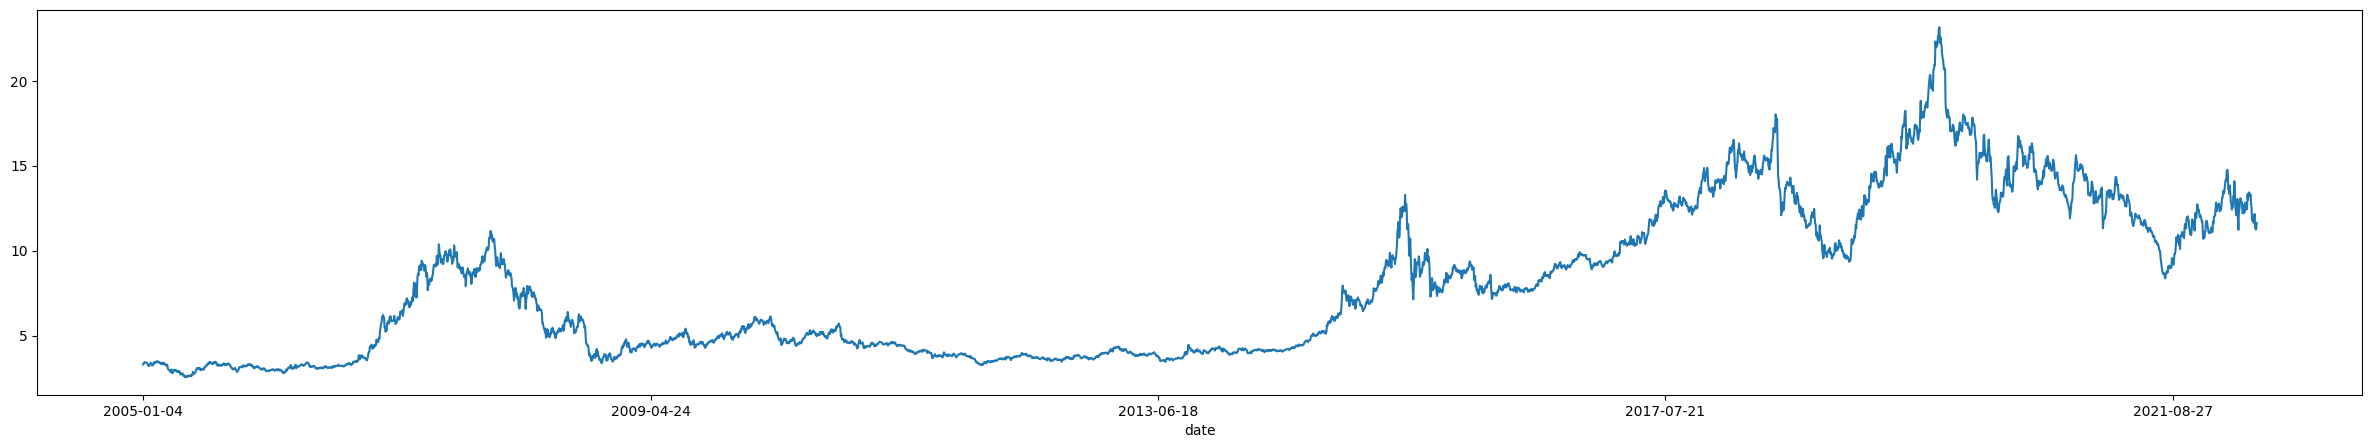

In [4]:
stock_data[stock_data["ticker"] == "sh600004"].set_index('date')["close"].plot(figsize=(30, 5))

In [5]:
df_1stock = stock_data[stock_data["ticker"] == "sh600004"].set_index('date')
df_1stock[["close"]] = df_1stock[["close"]].pct_change()
df_1stock = pd.DataFrame(df_1stock['close']).dropna()

For algorithm to begin we need start value (equal to the stock price for convenience), floor value that we do not want to go below,
and others that can be easily seen in the code.

In [6]:
start = 3.30
floor = 0.95
risky_r = df_1stock
#Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:] = 0.03/252

In [7]:
dates = df_1stock.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 6

# History
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)


for step in range(n_steps):
  cushion = (account_value - floor_value)/account_value
  risky_w = m*cushion
  risky_w = np.minimum(risky_w, 1)  # to avoid leveraging the money
  risky_w = np.maximum(risky_w, 0)  # well, that just makes sense, we cannot invest negative values
  safe_w = 1-risky_w

  risky_alloc = account_value*risky_w
  safe_alloc = account_value*safe_w

  # recomputing value of account i.e. invest money with respect to returns
  account_value = risky_alloc*(1 + risky_r.iloc[step]) + safe_alloc*(1 + safe_r.iloc[step])

  # collecting  data for the history
  account_history.iloc[step] = account_value
  cushion_history.iloc[step] = cushion
  risky_w_history.iloc[step] = risky_w

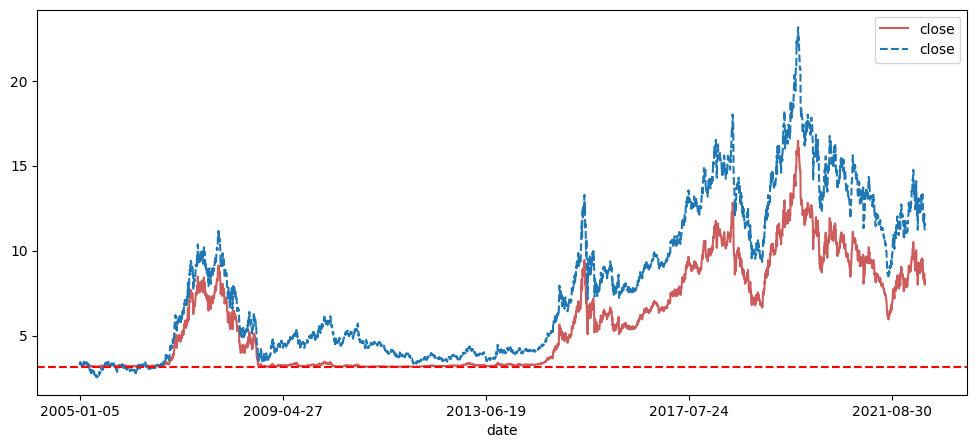

In [8]:
df = stock_data[stock_data["ticker"] == "sh600004"].set_index('date')
df = pd.DataFrame(df['close'])['2005-01-05':]/3.30*start

ax1 = account_history.plot(figsize=(12, 5), color="indianred")
df.plot(ax = ax1, style='--')
ax1.axhline(y=floor_value, color='r', linestyle="--")

<AxesSubplot:xlabel='date'>

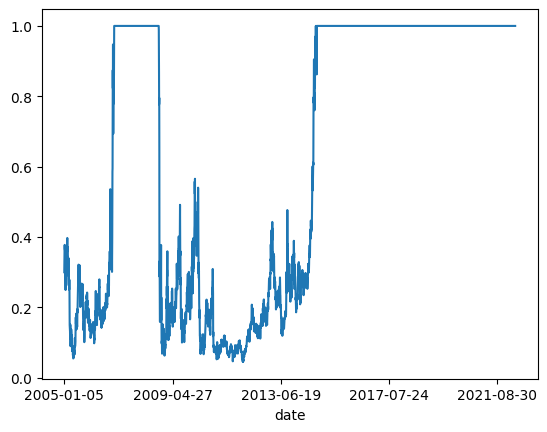

In [47]:
risky_w_history.plot(legend=False) # risky weight of asset

This example provides very basic concept of CPPI strategy, the most noticeable part in red dotted line which is floor value of portfolio, as might be seen, unlike our CPPI portfolio, blue line (buy and hold) intersects floor-line, which means value of portfolio goes below maximum drawdown required. This result might be dramatic in terms of financial planning, for instance it might affect person's retirement or college fund.

Let us add to our model a risk free asset, which in our case will be 10Y Chinese Government bonds with riskfree_rate=0.035. As we can see it will increase our profitability.

https://tradingeconomics.com/china/government-bond-yield

In [10]:
def run_cppi_0(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.035):

    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series):  # in that case we can work with not only DataFrames but also with Series.
        risky_r = pd.DataFrame(risky_r, columns=["rets"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/252

    # History
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value

        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)  # to avoid leveraging the money
        risky_w = np.maximum(risky_w, 0)  # well, that just makes sense, we cannot invest negative values

        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w

        # recomputing value of account i.e. invest money with respect to returns
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])

        # collecting  data for the history
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value

    risky_wealth = start*(1+risky_r).cumprod()

    backtest_result = {
                        "Wealth": account_history,            # Asset Value History
                        "Risky Wealth": risky_wealth,
                        "Risk Budget": cushion_history,       # Risk Budget History
                        "Risky Allocation": risky_w_history,  # Risky Weight History
                        "m": m,
                        "start": start,
                        "floor": floor,
                        "risky_r":risky_r,
                        "safe_r": safe_r
                      }
    return backtest_result

<AxesSubplot:xlabel='date'>

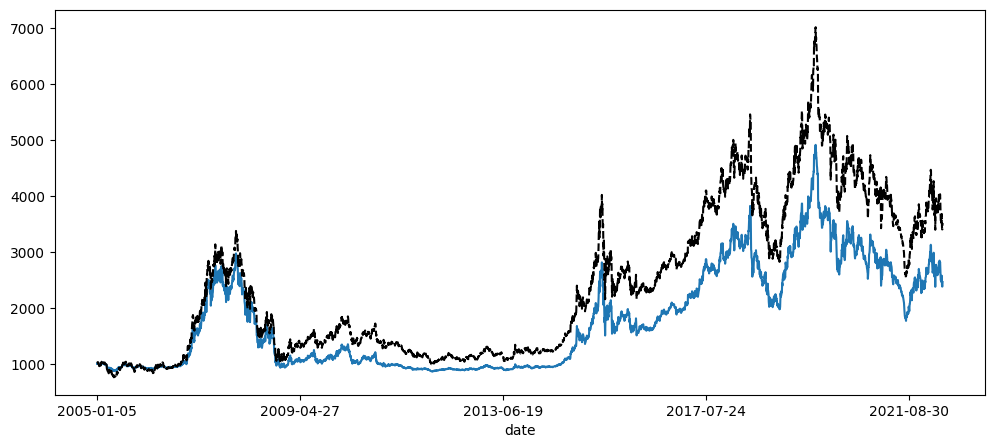

In [11]:
btr0 = run_cppi_0(df_1stock)
ax2 = btr0["Wealth"].plot(figsize=(12, 5), legend=False)
btr0["Risky Wealth"].plot(ax=ax2, style="k--", legend=False)

So, now it's not for upside but for downside protection, we have a static floor to hedge against excessive downside. In this concrete example difference might seem insignificant, but in reality it is indeed noticeable.

In [29]:
def drawdown(return_series: pd.Series):
    ## Calculate the wealth index, the previous peaks, and the percentage drawdown

    wealth_index = 1000 * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})

In [30]:
x = btr0["Wealth"].pct_change().dropna().squeeze()
max_dd_cppi0 = drawdown(x).Drawdown.min()  # min since negative numbers
print(f'max CPPI Drawdown - {max_dd_cppi0}')

y = btr0["Risky Wealth"].pct_change().dropna().squeeze()
max_dd_0 = drawdown(y).Drawdown.min()  # min since negative numbers
print(f'max Risky Asset Drawdown - {max_dd_0}')

max CPPI Drawdown - -0.706450002957439
max Risky Asset Drawdown - -0.7069892473118282


In [48]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth ** (periods_per_year / n_periods) - 1


def annualize_vol(r, periods_per_year):
    return r.std() * (periods_per_year ** 0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    rf_per_period = (1 + riskfree_rate) ** (1 / periods_per_year) - 1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret / ann_vol

## Adding drawdown
Sometimes when the value of our assets goes up, it becomes less likely for it to drop to our floor value, which is the share of our invested capital. Lets modify this parameter and just keep in mind that fraction we can afford to lose, not the value we want to keep.

Now, let's add a drawdown constraint, our floor value is not the static value anymore, it's actually a dynamic value that changes over time as our peak changes over time. So let's say we had set drawdown at 25 percent, all we have to do is update our floor value, which is no longer a static number.


In [31]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.035, drawdown=None):

    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start * floor
    peak = account_value

    if isinstance(risky_r, pd.Series):  # in that case we can work with not only DataFrames but also with Series.
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate / 252

    # History
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):

        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak * (1 - drawdown)

        cushion = (account_value - floor_value) / account_value
        risky_w = m * cushion
        risky_w = np.minimum(risky_w, 1)  # to avoid leveraging the money
        risky_w = np.maximum(risky_w, 0)  # well, that just makes sense, we cannot invest negative values

        safe_w = 1 - risky_w
        risky_alloc = account_value * risky_w
        safe_alloc = account_value * safe_w

        # recomputing value of account i.e. invest money with respect to returns
        account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])

        # collecting  data for the history
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak

    risky_wealth = start * (1 + risky_r).cumprod()

    backtest_result = {
                        "Wealth": account_history,           # Asset Value History
                        "Risky Wealth": risky_wealth,
                        "Risk Budget": cushion_history,      # Risk Budget History
                        "Risky Allocation": risky_w_history, # Risky Weight History
                        "m": m,
                        "start": start,
                        "floor": floor,
                        "risky_r": risky_r,
                        "safe_r": safe_r,
                        "drawdown": drawdown,
                        "peak": peak_history,
                        "floor": floorval_history
                        }
    return backtest_result

In [32]:
btr = run_cppi(df_1stock, m=6, start=100, drawdown=0.25, riskfree_rate=0.035)

<AxesSubplot:xlabel='date'>

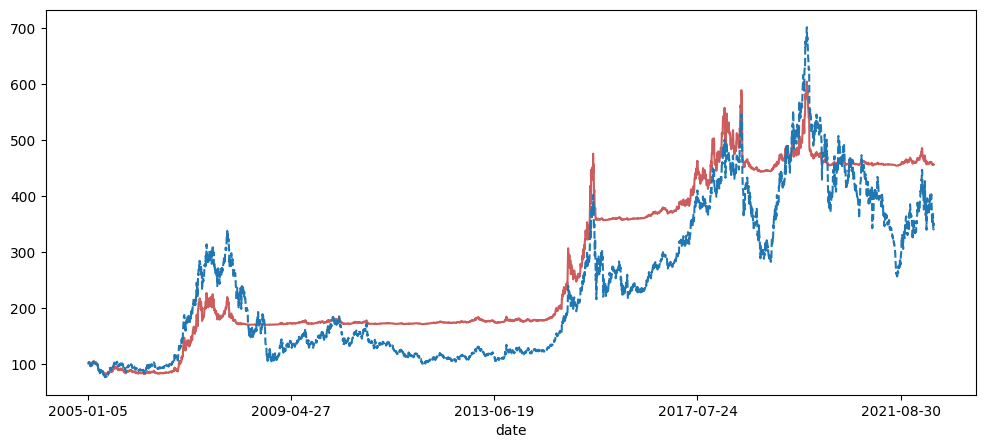

In [45]:
ax = btr["Wealth"].plot(figsize=(12, 5), color="indianred", legend=False)
btr["Risky Wealth"].plot(ax=ax, style="--", legend=False)

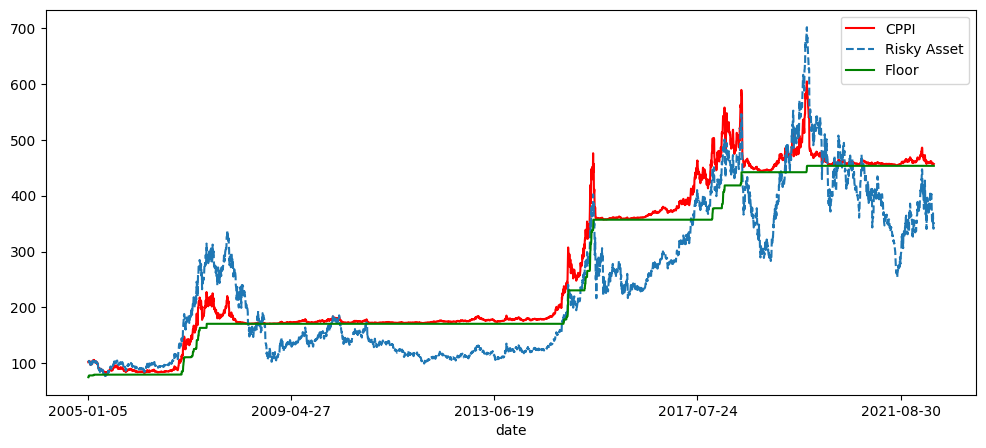

In [46]:
ax3 = btr["Wealth"].plot(figsize=(12, 5), color="red", label="CPPI")
btr["Risky Wealth"].plot(ax=ax3, style="--", label="Risky Asset")
btr["floor"].plot(ax=ax3, legend=False, color='green', label="Floor")
ax3.legend(["CPPI", "Risky Asset", "Floor"])

Now it becomes obvious how powerful CPPI strategy can be just by looking at two previous graphs.

### Stock Picking
Well, CPPI is great, right... And one of the pros is if you trade consistently nothing can go wrong with any asset (the only danger here is Gap Risk, so we will prefer something not that volatile), but anyway let's choose some stocks to invest in.

In [54]:
one_big_vol_dict = {}

for ticker in list(stock_data['ticker'].unique()):

    df = stock_data[stock_data["ticker"] == ticker].set_index('date')
    df[["close"]] = df[["close"]].pct_change()
    df = pd.DataFrame(df['close']).dropna()

    one_big_vol_dict[ticker] = annualize_vol(df, 252).tolist()[0]

Just like that we calculated Volatility of every equity in presented data, we'll go for small ones, since CPPI performs best at conditions of small volatility and Bullish markets (according to research which is also shown in EDHEC article).
BTW it takes about 40min - 2h to compute, just be aware of that.

In [55]:
dict1 = one_big_vol_dict
sorted_tuples = sorted(dict1.items(), key=lambda item: item[1])
print(sorted_tuples)
sorted_dict = {k: v for k, v in sorted_tuples}

print(sorted_dict)

[('sh603206', 0.0004969853101154947), ('sz001228', 0.0009628242055993645), ('sh601916', 0.18943432983861874), ('sh601229', 0.2037964237721437), ('sh601288', 0.2042439362256886), ('sh601077', 0.21305290576244115), ('sh601825', 0.24110815498134974), ('sh601728', 0.24160692583152366), ('sh688538', 0.24224046929876475), ('sh688739', 0.24977881038687016), ('sh600919', 0.25424357183478746), ('sh601988', 0.2557711928087647), ('sh601658', 0.2570648286439436), ('sh600900', 0.2575537402917576), ('sh601398', 0.26061592770401726), ('sh601997', 0.2607561438278479), ('sh688569', 0.26949660361655275), ('sh601939', 0.27146656324539853), ('sz003816', 0.2714729742031557), ('sh601019', 0.27318613370576744), ('sh601818', 0.2742387069206625), ('sh601857', 0.27452242958185036), ('sh601816', 0.27480881710701477), ('sz300983', 0.2844106349927259), ('sz002936', 0.28540008135247197), ('sh601568', 0.2866909866016274), ('sh600377', 0.28734205750425074), ('sz001965', 0.293938577502498), ('sh601328', 0.295725540645

In [56]:
picked_stocks = ['sh603122', 'sh603176', 'sh603191', 'sh603206', 'sh688170', 'sh688290', 'sh688320', 'z001228']

'''With Sharpe Ratio Respectfully'''
good_ShR = {
        'sh603122': 1.144377, ### 2022-02-17
        'sh603176': 1.008576, ### 2022-01-04
        'sh603191': 4.079811, ### 2022-04-29
        'sh603206': 183654.749332, ### 2022-05-09
        'sh688170': 3.397773, ### 2022-05-05
        'sh688290': 1.779515, ### 2022-05-05
        'sh688320': 1.111694, ### 2022-04-29
        'z001228': 8287.520334
        }


In [60]:
'''Wealth_dradown_ratio check'''

WddRatio = {}

def wealth_dradown_ratio(ticker):

    df = stock_data[stock_data["ticker"] == ticker ].set_index('date')
    df[["close"]] = df[["close"]].pct_change()
    df = pd.DataFrame(df['close']).dropna()

    btr = run_cppi(df, m=6, start=100, drawdown=0.25, riskfree_rate=0.035)

    WddRatio[ticker] = (btr["Wealth"].iloc[-1][0] - 100 )/ 0.25

In [61]:
for ticker in picked_stocks:
    wealth_dradown_ratio(ticker)

In [62]:
WddRatio

{'sh603206': 132.31357552581255,
 'sz001228': 244.32284541723664,
 'sh601916': -87.87109257634688,
 'sh601229': -37.00222922540058,
 'sh601288': 200.39331865673455}

### CONCLUSION
In conclusion I would like to say that I very much enjoyed the whole momentum of going right from the beginning and implementing the CPPI algorithm as well as going all the way to adding drawdown constraints. The technical beauty and results that a given algorithm can bring to one’s portfolio are incredible, although this also can be a basis for more complex strategies. Personally I would encourage everyone to try this out.